# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 30 ноября 2021, 08:30 

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups # поменял на openml, т.к. у меня новая версия

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
from scipy.spatial.distance import cdist
from collections import Counter
from sklearn.neighbors import KDTree

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'): # по деволту евклидовая
        super(MyKNeighborsClassifier, self).__init__()
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        # обучение сотсоит в запоминании обучающей выборки
        self.train_data = X
        self.train_labels = y
    
    def predict(self, X, cv_mode=False):
        predictions = np.ones(X.shape[0], dtype='int')
        if self.algorithm == 'brute':
            if self.metric == 'euclidean':
                distances = cdist(X, self.train_data, 'minkowski', p=2) # (size_x, size_train)
            elif self.metric == 'cosine':
                distances = cdist(X, self.train_data, 'cosine') # (size_x, size_train)
            ind = distances.argsort()[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            tree = KDTree(self.train_data)
            if self.metric == 'euclidean':
                _, ind = tree.query(X, k=self.n_neighbors)
            elif self.metric == 'cosine':
                _, ind = tree.query(X, k=self.n_neighbors, metric='cosine')

        labels = np.array([self.train_labels[i] for i in ind])
        
        # оптимизация для задания с кросс-валидацией
        if cv_mode:
            return labels

        for i, cur_labels in enumerate(labels):
                counter = Counter(cur_labels).most_common(1)
                predictions[i] = int(counter[0][0])
        return predictions
            
        

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [9]:
print(accuracy_score(y_test, my_clf_pred))
print(accuracy_score(y_test, sklearn_pred ))

1.0
1.0


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [11]:
%timeit clf.fit(X_train, y_train)

221 µs ± 5.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit my_clf.fit(X_train, y_train)

338 ns ± 13.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
%timeit clf.predict(X_test)

933 µs ± 245 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit my_clf.predict(X_test)

126 µs ± 3.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [19]:
%timeit clf.fit(X_train, y_train)

500 µs ± 144 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit my_clf.fit(X_train, y_train)

363 ns ± 37.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
%timeit clf.predict(X_test)

1.15 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%timeit my_clf.predict(X_test)

263 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [24]:
print(accuracy_score(y_test, my_clf_pred))
print(accuracy_score(y_test, sklearn_pred ))

1.0
1.0


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [25]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [26]:
data = newsgroups['data']
target = newsgroups['target']

In [27]:
print(data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer = CountVectorizer(min_df=3, max_df=4) # ограничил по частотности
tr_data = vectorizer.fit_transform(data)

In [30]:
X = tr_data.toarray()

In [32]:
X.shape # с 8952 алгоритм будет работать быстрее + не забываем о проклятии размерности

(11314, 8952)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [33]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

In [34]:
%%time
model = MyKNeighborsClassifier(n_neighbors=3, algorithm='brute')
cv_results = cross_validate(model, X, target, cv=3,
                            scoring={'accuracy_score': make_scorer(accuracy_score)})
np.mean(cv_results['test_accuracy_score'])

Wall time: 7min 53s


0.1807495323232434

это очень долго, поэтому написал свою версию cross_validate с оптимизацией подсчета оптимального k

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [39]:
# делит выборку на фолды для cv
def make_cv_folds(X, y, cv):
    X_folds = []
    y_folds = []
    fold_size = len(X) // cv
    for i in range(cv):
        if i == cv - 1: # в случае неделимости последний фолд будет больше
            X_folds.append(X[fold_size * i:])
            y_folds.append(y[fold_size * i:])
        else:
            X_folds.append(X[fold_size * i: fold_size * (i + 1)])
            y_folds.append(y[fold_size * i: fold_size * (i + 1)])

    return X_folds, y_folds

In [40]:
def optimal_k(X, y, cv=3, max_k=10, metric='euclidean'):
    # статистика точночти в зависимости от k
    stats_k = {k: [] for k in range(1, max_k + 1)}
    X_folds, y_folds = make_cv_folds(X, y, cv)
    
    # val_fold номер фолда для валидации
    for val_fold in range(cv):
        # собираем train
        X_train = []
        y_train = []
        for i in range(cv):
            if i != val_fold:
                X_train.extend(X_folds[i])
                y_train.extend(y_folds[i])
        X_train = np.array(X_train)
        y_train = np.array(y_train) 
        
        # val
        X_val = X_folds[val_fold]
        y_val = y_folds[val_fold]
        
        # для текущего разбиения предсказываем один раз
        model = MyKNeighborsClassifier(n_neighbors=max_k, metric=metric)
        model.fit(X_train, y_train)
        labels = model.predict(X_val, cv_mode=True)
        
        # по предсказанным лейблам для каждого k считаем accuracy
        for k in range(1, max_k + 1):
            predictions = np.empty(X_val.shape[0], dtype='int')
            for i, cur_labels in enumerate(labels):
                counter = Counter(cur_labels[:k]).most_common(1)
                predictions[i] = int(counter[0][0])
            stats_k[k].append(accuracy_score(y_val, predictions))
  

    return stats_k


средняя accuracy для k от 1 до 10 с Евклидовой метрикой и CountVectorizer

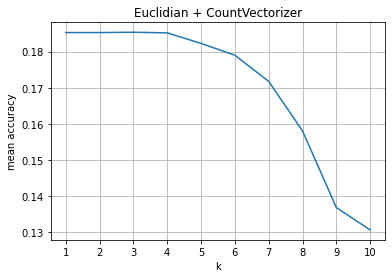

In [41]:
res = optimal_k(X, target)
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("Euclidian + CountVectorizer")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

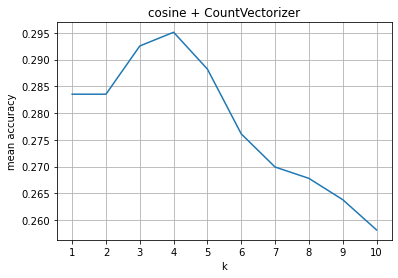

In [42]:
res = optimal_k(X, target, metric='cosine')
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("cosine + CountVectorizer")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer = TfidfVectorizer(min_df=3, max_df=4)
tr_data = vectorizer.fit_transform(data)

In [48]:
X = tr_data.toarray()
X.shape

(11314, 8952)

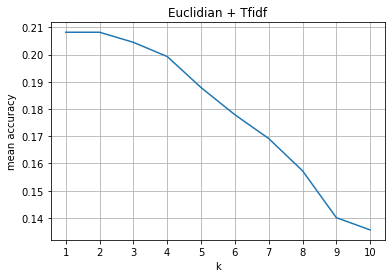

In [49]:
res = optimal_k(X, target)
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("Euclidian + Tfidf")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

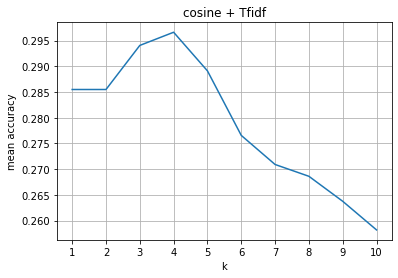

In [50]:
res = optimal_k(X, target, metric='cosine')
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("cosine + Tfidf")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

Последняя модель оказалась эффективнее, буду тестировать ее

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [51]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [52]:
vectorizer = TfidfVectorizer(min_df=3, max_df=4)
tr_data = vectorizer.fit_transform(newsgroups['data'])
X_train = tr_data.toarray()
y_train = newsgroups['target']

In [53]:
X_train.shape, y_train.shape

((11314, 8952), (11314,))

максимум был при 4 соседях

In [54]:
model = MyKNeighborsClassifier(n_neighbors=4, metric='cosine')
model.fit(X_train, y_train)

In [55]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [56]:
test_data = vectorizer.transform(newsgroups['data'])
X_test = test_data.toarray()
y_test = newsgroups['target']

In [57]:
X_test.shape, y_test.shape

((7532, 8952), (7532,))

In [58]:
pred = model.predict(X_test)

In [59]:
accuracy_score(y_test, pred)

0.25955921402018056

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

accuracy получилась 0.26, немного ниже, чем на кросс-валидации (~0.293). Качество отличается, потому что валидационная выборка сложно, но становится частью обучающего набора, и точность не обязана совпасть на тестовой выборке

# Линейные модели (5 баллов)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if len(X) != len(y):
        raise ValueError("X and y must have the same length")
        
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X)) if shuffle else np.arange(len(X))
    
    cur_batch_size = 0
    amount_batch = 0 # если размер датасета не делится на batch_size
    # то не возвращаем последний маленький батч
    max_amount_batch = len(X) // batch_size
    
    X_batch = []
    y_batch = []
    for ind in perm:
        X_batch.append(X[ind])
        y_batch.append(y[ind])
        cur_batch_size += 1
        if cur_batch_size == batch_size:
            cur_batch_size = 0
            amount_batch += 1
            yield (np.array(X_batch), np.array(y_batch))
            if amount_batch == max_amount_batch:
                break
            X_batch = []
            y_batch = []

In [55]:
# Теперь можно сделать генератор по данным ()
#my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [8]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    return 1. / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        pred = self.predict(X_batch)
        if self.model_type == 'lin_reg':
            loss = np.sum(np.square(pred - y_batch)) / len(X_batch)
        else:
            pred = np.clip(pred, 1e-10, 1 - 1e-10) # избегаем численной нестабильности
            loss = -np.sum(y_batch * np.log(pred) + (np.ones_like(y_batch) - y_batch) * np.log(np.ones_like(pred) - pred)) / len(X_batch)
        
        # l2 regularization
        loss += np.sum(np.square(self.weights)) / self.C
        
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            loss_grad = 2 * X_batch.T @  (X_batch @ self.weights - y_batch) / len(X_batch)
        else:
            loss_grad = np.zeros_like(self.weights)
            for xi, yi in zip(X_batch, y_batch):
                loss_grad -= (yi - sigmoid(xi @ self.weights)) * xi
            
        
        # l2 regularization
        loss_grad += 2 * self.weights / self.C
        
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
    
    def fit(self, X, y, n_log=1):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        _, k = X.shape
        # Нужно инициализровать случайно веса
        self.weights = np.random.randn(k)
        num_iter = 0
        cumloss = 0
        for n in range(self.max_epoch):
            new_epoch_generator = self.batch_generator
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                cumloss += batch_loss
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                # batch_loss = self.calc_loss(X_batch, y_batch)
                if num_iter != 0 and num_iter % n_log == 0:
                  self.errors_log['iter'].append(batch_num)
                  self.errors_log['loss'].append(cumloss / n_log)
                  cumloss = 0
                num_iter += 1
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        if self.model_type == 'lin_reg':
            y_hat = X @ self.weights
        else:
            y_hat = sigmoid(X @ self.weights)
            #y_hat = 1 if p >= 0.5 else 0
        return y_hat
    
    
    def get_weights(self):
        return self.weights.copy()

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [9]:
def plot_decision_boundary(clf):
    # рисует границу для классификации
    w1, w2 = clf.get_weights()[:2]
    print(f"weights: ({w1}, {w2})")
    x = np.linspace(-10, 10)
    # w1 * x + w2 * y = threshold = 0.5
    y = (0.5 - w1 * x) / w2
    plt.plot(x, y)

In [10]:
# data generation
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

weights: (0.1590571223313973, -0.041002167050507764)


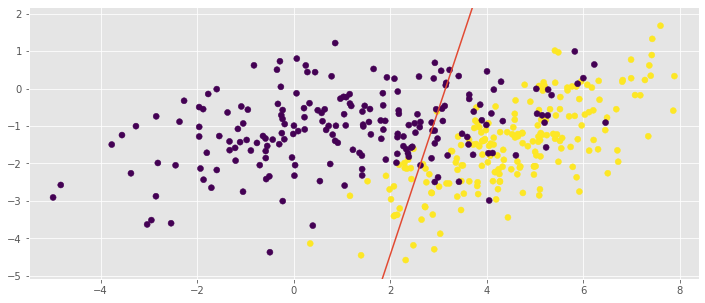

In [11]:
# fit model
my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1)
model = MySGDClassifier(my_batch_generator, model_type='log_reg')
model.fit(X, y, n_log = 10)
# draw boundary
plot_decision_boundary(model)

# draw data
plt.xlim((np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5))
plt.ylim((np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5))
plt.scatter(X[:,0], X[:,1], c=y);

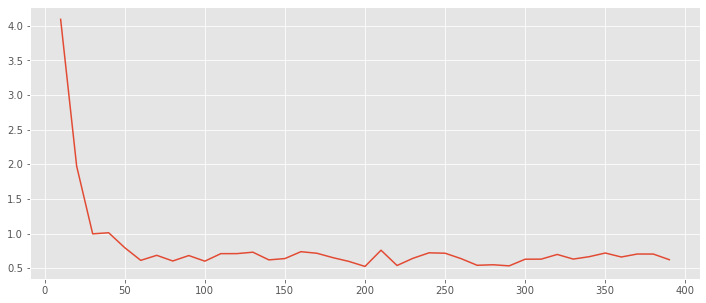

In [12]:
plt.plot(model.errors_log['iter'], model.errors_log['loss']);

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [13]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

In [14]:
X.shape

(100000, 10)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

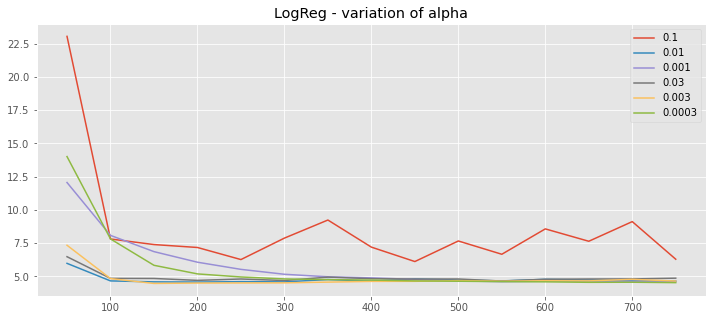

In [15]:
for alpha in np.array([0.1, 0.01, 0.001, 0.03, 0.003, 3e-4]):
    # fit model
    my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=128)
    model = MySGDClassifier(my_batch_generator, model_type='log_reg', alpha=alpha)
    model.fit(X, y, n_log = 50)
    plt.plot(model.errors_log['iter'], model.errors_log['loss'], label=str(alpha))
plt.title("LogReg - variation of alpha")
plt.legend();

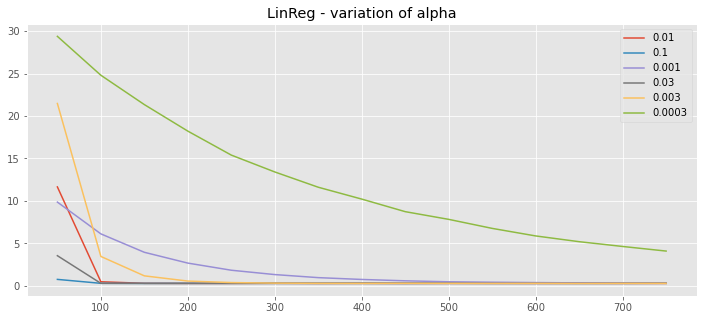

In [16]:
for alpha in np.array([0.01, 0.1, 0.001, 0.03, 0.003, 3e-4]):
    # fit model
    my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=128)
    model = MySGDClassifier(my_batch_generator, model_type='lin_reg', alpha=alpha)
    model.fit(X, y, n_log = 50)
    plt.plot(model.errors_log['iter'], model.errors_log['loss'], label=str(alpha))
plt.title("LinReg - variation of alpha")
plt.legend();

В целом везде была неплохая сходимость, кроме лучая логрега и alpha=0.01. Видно, что loss скачет, это потому что с таким шагом SGD мы постоянно перепрыгиваем минимум. Отсюда можно сделать вывод, что не стоит брать такие большие alpha

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:10: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-x))
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:48: RuntimeWarning: overflow encountered in double_scalars
  loss += np.sum(np.square(self.weights)) / self.C
D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:48: RuntimeWarning: overflow encountered in square
  loss += np.sum(np.square(self.weights)) / self.C
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:69: RuntimeWarning: overflow encountered in true_divide
  loss_grad += 2 * self.weights / self.C
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:65: RuntimeWarning: invalid value encountered in matmul
  loss_grad -= (yi - sigmoid(xi @ self.weights)) * xi
C:\Users\jaaj\AppData\Local\Tem

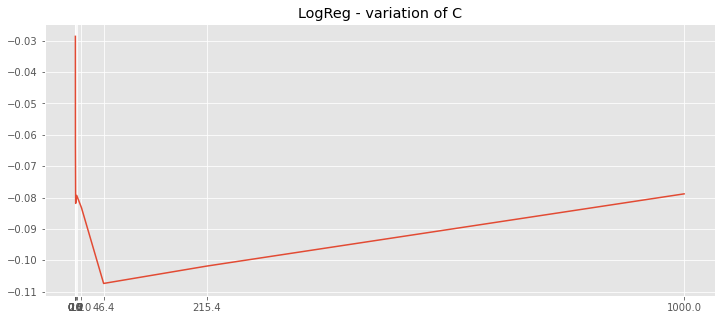

In [17]:
diff_c = np.logspace(3, -3, 10)
mean_w = []
for C in diff_c:
    my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=128)
    model = MySGDClassifier(my_batch_generator, model_type='log_reg', C=C)
    model.fit(X, y, n_log = 50)
    mean_w.append(np.mean(model.get_weights()))
plt.title("LogReg - variation of C")
plt.xticks(diff_c)
plt.plot(diff_c, mean_w);

In [21]:
diff_c

array([1.00000000e+03, 2.15443469e+02, 4.64158883e+01, 1.00000000e+01,
       2.15443469e+00, 4.64158883e-01, 1.00000000e-01, 2.15443469e-02,
       4.64158883e-03, 1.00000000e-03])

Самый лучший вариант вышел для самого малого C, также видно, что при увеличении C абсолютные значения весов не будут самыми маленькими, например для 1000

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:42: RuntimeWarning: overflow encountered in square
  loss = np.sum(np.square(pred - y_batch)) / len(X_batch)
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:48: RuntimeWarning: overflow encountered in double_scalars
  loss += np.sum(np.square(self.weights)) / self.C
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:48: RuntimeWarning: overflow encountered in square
  loss += np.sum(np.square(self.weights)) / self.C
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:61: RuntimeWarning: overflow encountered in matmul
  loss_grad = 2 * X_batch.T @  (X_batch @ self.weights - y_batch) / len(X_batch)
C:\Users\jaaj\AppData\Local\Temp/ipykernel_1144/186066617.py:61: RuntimeWarning: invalid value encountered in matmul
  loss_grad = 2 * X_

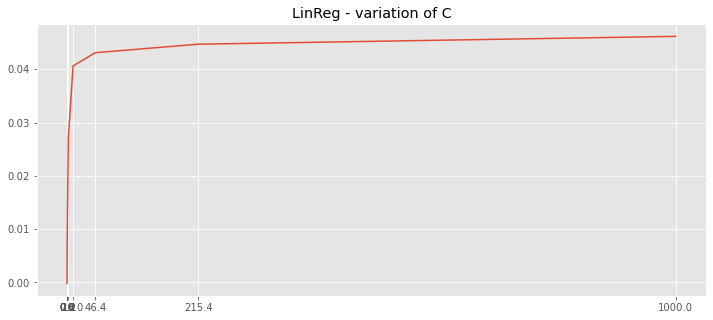

In [18]:
mean_w = []
for C in diff_c:
    my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=128)
    model = MySGDClassifier(my_batch_generator, model_type='lin_reg', C=C)
    model.fit(X, y, n_log = 50)
    mean_w.append(np.mean(model.get_weights()))
plt.title("LinReg - variation of C")
plt.xticks(diff_c)
plt.plot(diff_c, mean_w);

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

для линрега ситуация аналогична: меньшие значения при меньшем C